In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.sparse import diags,eye
from scipy.sparse.linalg import spsolve
from scipy.optimize import root, root_scalar
from src.BloodVesselPeriodic import Grid1D, BloodVessel1Dperiodic

## 0. Grid
Esta parte deberia estar bien

In [12]:
L = 1.0
Np = 5
stretch = 1.1  # Equidistant grid

grid = Grid1D(L, Np, stretch, stretch_type='test')

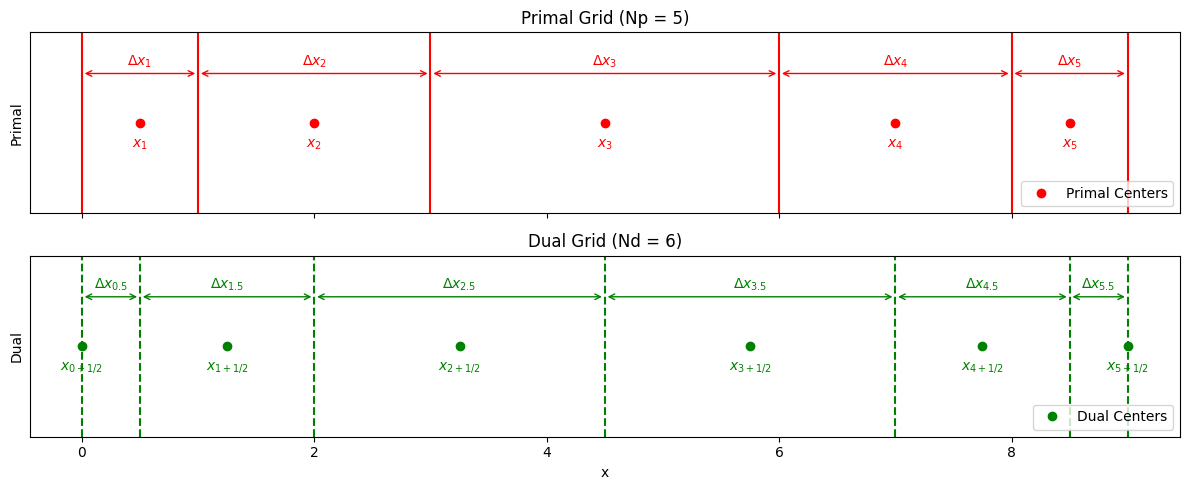

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(12, 5), sharex=True)

# PRIMAL GRID
axs[0].set_title(f"Primal Grid (Np = {Np})")
for x in grid.x_faces:
    axs[0].axvline(x, color='red')
axs[0].plot(grid.x_centers, np.zeros_like(grid.x_centers), 'ro', label='Primal Centers')
axs[0].set_yticks([])
axs[0].set_ylabel("Primal")

for i, xc in enumerate(grid.x_centers, start=1):
    axs[0].text(xc, -0.015, f"$x_{{{i}}}$", color='red', ha='center')

arrow_y = 0.03
for i in range(Np):
    start = grid.x_faces[i]
    end = grid.x_faces[i + 1]
    axs[0].annotate('', xy=(end, arrow_y), xytext=(start, arrow_y),
                    arrowprops=dict(arrowstyle='<->', color='red'))
    mid = 0.5 * (start + end)
    axs[0].text(mid, arrow_y + 0.005, f"$\Delta x_{{{i+1}}}$", color='red', ha='center')

axs[0].legend(loc='lower right')

# DUAL GRID
axs[1].set_title(f"Dual Grid (Nd = {Np + 1})")
for x in grid.x_dual_edges:
    axs[1].axvline(x, color='green', linestyle='--')
axs[1].plot(grid.x_dual_centers, np.zeros_like(grid.x_dual_centers), 'go', label='Dual Centers')
axs[1].set_yticks([])
axs[1].set_xlabel("x")
axs[1].set_ylabel("Dual")

for j, xd in enumerate(grid.x_dual_centers):
    i_label = j + 1
    axs[1].text(xd, -0.015, f"$x_{{{i_label-1}+1/2}}$", color='green', ha='center')

for i in range(len(grid.x_dual_edges) - 1):
    start = grid.x_dual_edges[i]
    end = grid.x_dual_edges[i + 1]
    axs[1].annotate('', xy=(end, arrow_y), xytext=(start, arrow_y),
                    arrowprops=dict(arrowstyle='<->', color='green'))
    mid = 0.5 * (start + end)
    i_label = i + 0.5
    axs[1].text(mid, arrow_y + 0.005, f"$\Delta x_{{{i_label}}}$", color='green', ha='center')

axs[1].legend(loc='lower right')
plt.tight_layout()
plt.show()

## 4th test: Unsteady Test (paper)

$A(x,t) = t*sin(2\pi x) + u_c$

$q(x,t) = \frac{cos(2\pi x)}{2\pi}$

$p(x,t) = p_e + K \sqrt{\frac{A}{A_0}} + \frac{\Tau}{A_0\sqrt{A}} \frac{\partial A}{\partial t} =  K \sqrt{\frac{A}{A_0}} + \frac{\Tau}{A_0\sqrt{A}} sin(2\pi x) = \frac{A_{0} K \sqrt{\frac{t \sin{\left(2 \pi x \right)} + u_{c}}{A_{0}}} + \frac{\Tau \sin{\left(2 \pi x \right)}}{\sqrt{t \sin{\left(2 \pi x \right)} + u_{c}}}}{A_{0}} $

$ \tilde{s} =  \frac{\left(- A_{0} \alpha \rho t \cos^{2}{\left(2 \pi x \right)} - 2 A_{0} \alpha \rho \left(t \sin{\left(2 \pi x \right)} + u_{c}\right) \sin{\left(2 \pi x \right)} + 2 \pi^{2} \left(\frac{K t \left(t \sin{\left(2 \pi x \right)} + u_{c}\right)^{3}}{\sqrt{\frac{t \sin{\left(2 \pi x \right)} + u_{c}}{A_{0}}}} - \Tau t \left(t \sin{\left(2 \pi x \right)} + u_{c}\right)^{\frac{3}{2}} \sin{\left(2 \pi x \right)} + 2 \Tau \left(t \sin{\left(2 \pi x \right)} + u_{c}\right)^{\frac{5}{2}}\right)\right) \cos{\left(2 \pi x \right)}}{2 \pi A_{0} \rho \left(t \sin{\left(2 \pi x \right)} + u_{c}\right)^{2}}$

$\tilde{s}_{conv}=- \frac{\alpha t \cos^{3}{\left(2 \pi x \right)}}{2 \pi \left(t \sin{\left(2 \pi x \right)} + u_{c}\right)^{2}} - \frac{\alpha \sin{\left(2 \pi x \right)} \cos{\left(2 \pi x \right)}}{\pi \left(t \sin{\left(2 \pi x \right)} + u_{c}\right)}$

$\tilde{s}_{diff} = \frac{\pi \Tau \left(t \sin{\left(2 \pi x \right)} + 2 u_{c}\right) \cos{\left(2 \pi x \right)}}{A_{0} \rho \sqrt{t \sin{\left(2 \pi x \right)} + u_{c}}}$

$\tilde{s}_{press} = \frac{\pi K t \sqrt{t \sin{\left(2 \pi x \right)} + u_{c}} \cos{\left(2 \pi x \right)}}{\sqrt{A_{0}} \rho}$

In [6]:
import sympy as sp
x, t, rho, A0, K, uc, alpha, t, tau = sp.symbols(r'x t \rho A_0 K u_c \alpha t \Tau', real=True, positive=True)
A = (t * sp.sin(2 * sp.pi * x)+uc)
q  = sp.cos(2 * sp.pi * x) / (2 * sp.pi)
u = q / A
P = (K * sp.sqrt(A/A0) + tau / (A0 * sp.sqrt(A)) * sp.sin(2 * sp.pi * x)).simplify()
phi = tau / (A0 * sp.sqrt(A))
p_tilde = K * sp.sqrt(A/A0)
#print(sp.latex(P))


#print(sp.latex((sp.diff(alpha * A*u**2,x) + A/rho * sp.diff(P, x)).simplify()))
#(sp.diff(alpha * A*u**2,x).simplify() )
# print(sp.latex(sp.diff(alpha * q**2/A,x)))
sp.integrate(sp.diff(alpha * q**2/A,x),x).simplify()

#print(sp.latex(-sp.diff(phi * sp.diff(q,x),x).simplify()* A/rho))
#-sp.diff(phi * sp.diff(q,x),x).simplify()* A/rho

#sp.integrate((A/rho * sp.diff(P,x) - A /rho * sp.diff(P-p_tilde,x).simplify()).simplify(),x).simplify()

\alpha*(t**2*cos(2*pi*x)**2 - 2*t*u_c*sin(2*pi*x) - 2*u_c**2)/(4*pi**2*t**2*(t*sin(2*pi*x) + u_c))

In [7]:
L = 1.0
A0ref = 3.1416e-4
Kref = 80
pe = 0
rho = 1050
tF = 0.1
dt = 5e-3

grid = Grid1D(L=1.0, Np=100, stretch_factor=1.0, stretch_type='uniform')

blood_solution = BloodVessel1Dperiodic(grid = grid, flux_type='kolgan', tF = 0.1, dt =dt, rho=rho, Tau=0.0, A0=A0ref, K = Kref, BC_type = "test_unsteady")
q_solutions, A_solutions, p_solutions, q_star_solutions, q_starstar_solutions, u_solutions, t_sol = blood_solution.solve_blood_vessel()
q_final = q_solutions[-1]
A_final = A_solutions[-1]
p_final = p_solutions[-1]


0.0  /  0.1  dt:  0.005  q_max:  0.15911621020836156  A_max:  4.004993158908395  p_max:  8952.655194947396
0.005  /  0.1  dt:  0.005  q_max:  0.15910514427329386  A_max:  4.0100030069586525  p_max:  8958.302905886801
0.01  /  0.1  dt:  0.005  q_max:  0.159093699401972  A_max:  4.015039064952576  p_max:  8963.976609304818
0.015  /  0.1  dt:  0.005  q_max:  0.15908215356586472  A_max:  4.0200973933398  p_max:  8969.671822138605
0.02  /  0.1  dt:  0.005  q_max:  0.1590709527267117  A_max:  4.025176294510067  p_max:  8975.386594258738
0.025  /  0.1  dt:  0.005  q_max:  0.15906053134127573  A_max:  4.030277005293302  p_max:  8981.122279017112
0.030000000000000002  /  0.1  dt:  0.005  q_max:  0.15905117029756993  A_max:  4.0354019733268425  p_max:  8986.881586444673
0.035  /  0.1  dt:  0.005  q_max:  0.1590431289872657  A_max:  4.040548750393544  p_max:  8992.661722937486
0.04  /  0.1  dt:  0.005  q_max:  0.1590649072429494  A_max:  4.045708917893441  p_max:  8998.4532031689
0.045  /  0.1  d

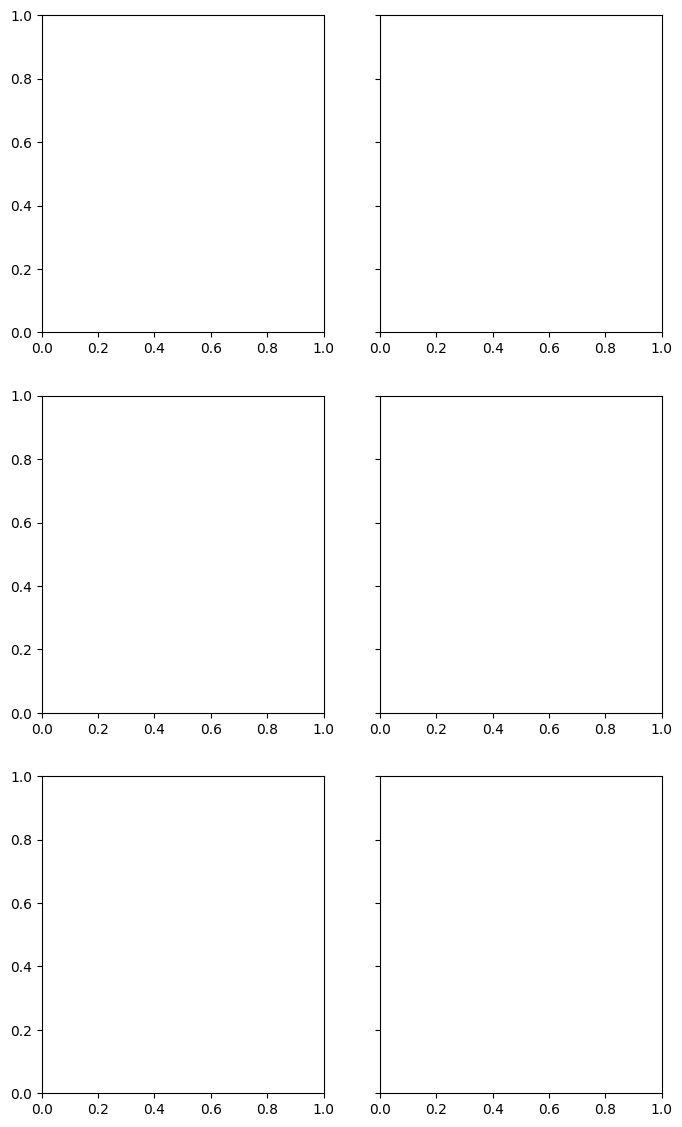

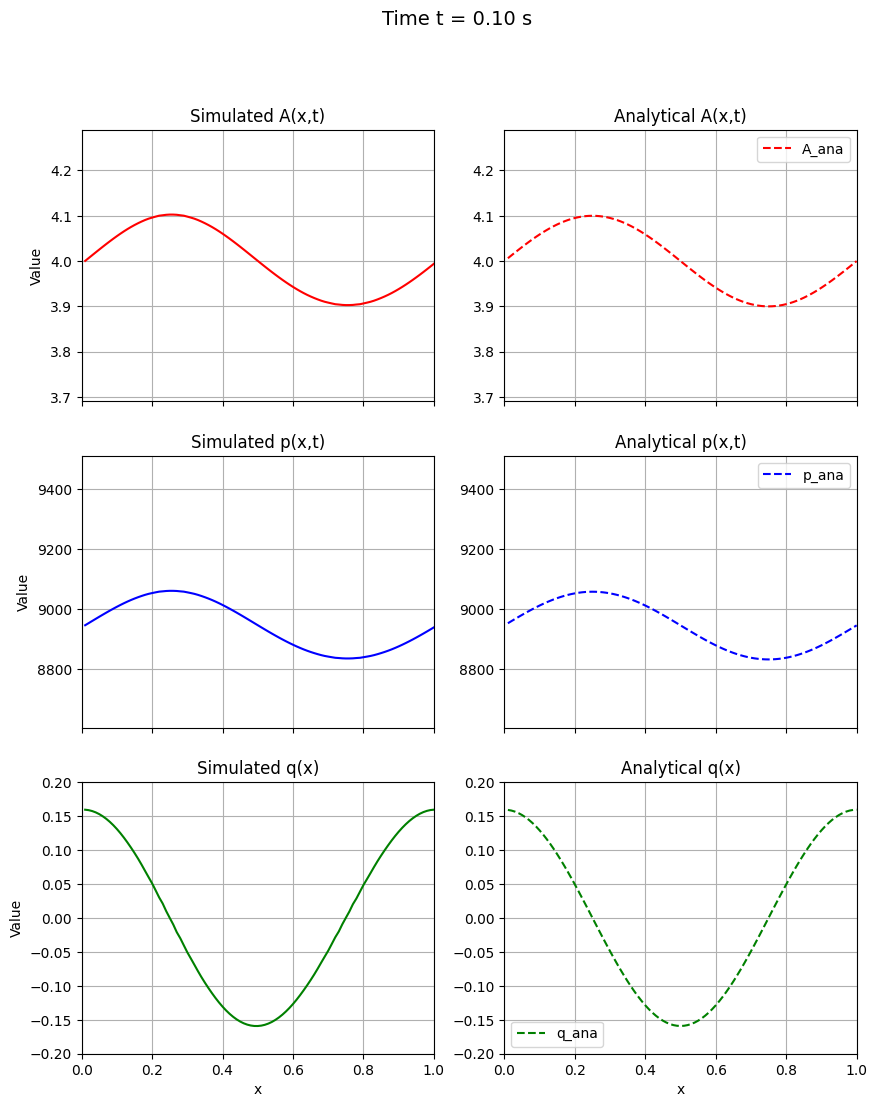

In [10]:
A_solutions = np.array(A_solutions)
p_solutions = np.array(p_solutions)
q_solutions = np.array(q_solutions)

# Constants and data
n_timesteps = len(A_solutions)
x = np.linspace(grid.x_dual_centers[1], L, len(A_solutions[0]), endpoint=True)

# Set up the figure
fig, axes = plt.subplots(3, 2, figsize=(8, 14), sharey=True)
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

fig, axes = plt.subplots(3, 2, figsize=(10, 12), sharex=True)
(ax_A_sim, ax_A_ana,
 ax_p_sim, ax_p_ana,
 ax_q_sim, ax_q_ana) = axes.flatten()

line_A_sim, = ax_A_sim.plot([], [], color='red', label='A_sim')
line_A_ana, = ax_A_ana.plot([], [], '--', color='red', label='A_ana')

line_p_sim, = ax_p_sim.plot([], [], color='blue', label='p_sim')
line_p_ana, = ax_p_ana.plot([], [], '--', color='blue', label='p_ana')

line_q_sim, = ax_q_sim.plot([], [], color='green', label='q_sim')
line_q_ana, = ax_q_ana.plot([], [], '--', color='green', label='q_ana')

ax_A_sim.set_title("Simulated A(x,t)"); ax_A_ana.set_title("Analytical A(x,t)")
ax_p_sim.set_title("Simulated p(x,t)"); ax_p_ana.set_title("Analytical p(x,t)")
ax_q_sim.set_title("Simulated q(x)");   ax_q_ana.set_title("Analytical q(x)")

for ax in axes[:, 0]:
    ax.set_ylabel("Value")
for ax in axes[-1]:
    ax.set_xlabel("x")

for ax in axes.flatten():
    ax.set_xlim(0, 1)
    ax.grid(True)

# Legends
ax_A_ana.legend()
ax_p_ana.legend()
ax_q_ana.legend()

A_min, A_max = tF + 4, -tF + 4
ax_A_sim.set_ylim(A_min * 0.90, A_max * 1.1)
ax_A_ana.set_ylim(A_min * 0.90, A_max * 1.1)

# p = pe + K * sqrt(A/A0) --> plug in min/max A
p_min = pe + Kref * (np.sqrt(A_min / A0ref)-1)
p_max = pe + Kref * (np.sqrt(A_min / A0ref)-1)
ax_p_sim.set_ylim(p_min * 0.95, p_max * 1.05)
ax_p_ana.set_ylim(p_min * 0.95, p_max * 1.05)

# q(x) = q0 * cos(2πx) / (2π) --> range: [-q0/(2π), q0/(2π)]
q_min, q_max = -1/(2*np.pi), 1/(2*np.pi)
ax_q_sim.set_ylim(-0.20, 0.20)
ax_q_ana.set_ylim(-0.20, 0.20)

# Analytical functions
def analytical_A(x,t):
    return t*np.sin(2 * np.pi * x) + 4

def analytical_p(A):
    return pe + Kref * (np.sqrt(A / A0ref)-1)

def analytical_q(x):
    return np.cos(2*np.pi*x)/(2*np.pi)

# Update function for animation
def update(frame):
    t = frame * dt
    A_sim = A_solutions[frame]
    p_sim = p_solutions[frame]
    q_sim = q_solutions[frame]

    A_ana = analytical_A(x,t)
    p_ana = analytical_p(A_ana)
    q_ana = analytical_q(x)

    line_A_sim.set_data(x, A_sim)
    line_A_ana.set_data(x, A_ana)

    line_p_sim.set_data(x, p_sim)
    line_p_ana.set_data(x, p_ana)

    line_q_sim.set_data(x, q_sim)
    line_q_ana.set_data(x, q_ana)

    fig.suptitle(f"Time t = {t:.2f} s", fontsize=14)
    return (line_A_sim, line_A_ana, line_p_sim, line_p_ana, line_q_sim, line_q_ana)

# Create animation
ani = FuncAnimation(fig, update, frames=n_timesteps, blit=True)
HTML(ani.to_jshtml())

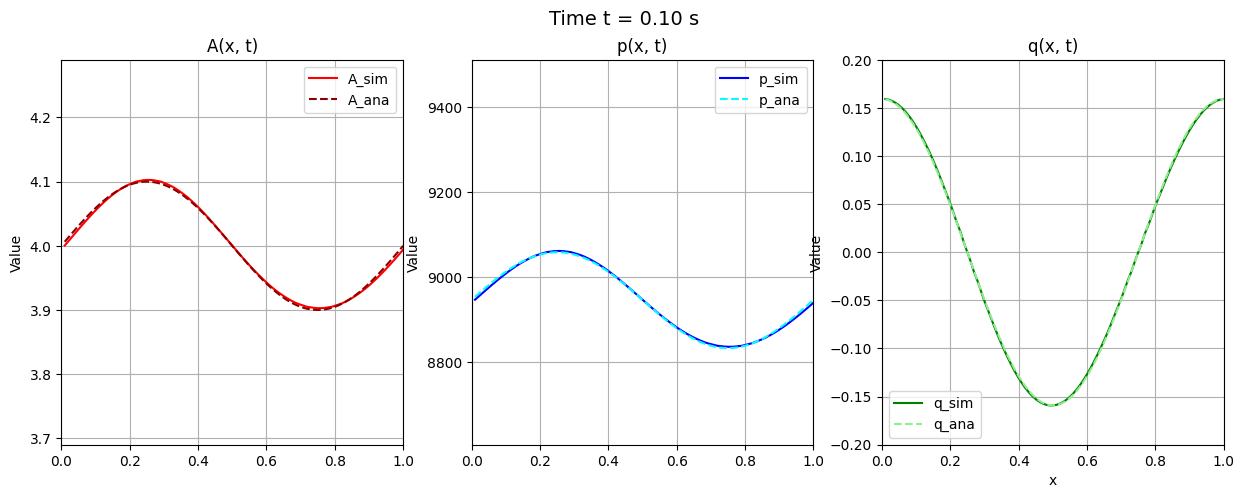

In [11]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

A_solutions = np.array(A_solutions)
p_solutions = np.array(p_solutions)
q_solutions = np.array(q_solutions)

# Constants and data
n_timesteps = len(A_solutions)
x = np.linspace(grid.x_dual_centers[1], L, len(A_solutions[0]), endpoint=True)

# Set up the figure
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)
ax_A, ax_p, ax_q = axes

line_A_sim, = ax_A.plot([], [], color='red', label='A_sim')
line_A_ana, = ax_A.plot([], [], '--', color='darkred', label='A_ana')

line_p_sim, = ax_p.plot([], [], color='blue', label='p_sim')
line_p_ana, = ax_p.plot([], [], '--', color='cyan', label='p_ana')

line_q_sim, = ax_q.plot([], [], color='green', label='q_sim')
line_q_ana, = ax_q.plot([], [], '--', color='lightgreen', label='q_ana')

ax_A.set_title("A(x, t)")
ax_p.set_title("p(x, t)")
ax_q.set_title("q(x, t)")

ax_q.set_xlabel("x")
for ax in axes:
    ax.set_ylabel("Value")
    ax.set_xlim(0, 1)
    ax.grid(True)
    ax.legend()

A_min, A_max = tF + 4, -tF + 4
ax_A.set_ylim(A_min * 0.90, A_max * 1.10)

p_min = pe + Kref * (np.sqrt(A_min / A0ref)-1)
p_max = pe + Kref * (np.sqrt(A_min / A0ref)-1)
ax_p.set_ylim(p_min * 0.95, p_max * 1.05)

ax_q.set_ylim(-0.20, 0.20)

# Analytical functions
def analytical_A(x, t):
    return t * np.sin(2 * np.pi * x) + 4

def analytical_p(A):
    return pe + Kref * (np.sqrt(A / A0ref) - 1)

def analytical_q(x):
    return np.cos(2 * np.pi * x) / (2 * np.pi)

# Update function for animation
def update(frame):
    t = frame * dt
    A_sim = A_solutions[frame]
    p_sim = p_solutions[frame]
    q_sim = q_solutions[frame]

    A_ana = analytical_A(x, t)
    p_ana = analytical_p(A_ana)
    q_ana = analytical_q(x)

    line_A_sim.set_data(x, A_sim)
    line_A_ana.set_data(x, A_ana)

    line_p_sim.set_data(x, p_sim)
    line_p_ana.set_data(x, p_ana)

    line_q_sim.set_data(x, q_sim)
    line_q_ana.set_data(x, q_ana)

    fig.suptitle(f"Time t = {t:.2f} s", fontsize=14)
    return (line_A_sim, line_A_ana, line_p_sim, line_p_ana, line_q_sim, line_q_ana)

# Create animation
ani = FuncAnimation(fig, update, frames=n_timesteps, blit=True)
HTML(ani.to_jshtml())


In [12]:
dt = 5e-3
stretch = 1
Np_list = [10, 20, 40, 80, 160]
# Np_list = [10, 20, 40, 80, 160]
# dt_list = [5e-3, 2.5e-3, 1.25e-3, 6.25e-4, 3.13e-4]
dt_list = dt/np.array([2**i for i in range( len(Np_list))])

L2_errors_q = []
L2_errors_A = []
L2_errors_p = []

def analytical_q(x_vals):
    return np.cos(2*np.pi*x_vals)/(2*np.pi)

def analytical_A(x_vals, t):
    return t * np.sin(2*np.pi*x_vals) + 4

def analytical_p(A_vals):
    return Kref * (np.sqrt(A_vals / A0ref) - 1)

# --- Convergence loop ---
for i, Np in enumerate(Np_list):
    print(f"Running simulation for Np = {Np}")

    grid = Grid1D(L=1.0, Np=Np, stretch_factor=1.0, stretch_type='uniform')

    blood_solution = BloodVessel1Dperiodic(grid = grid, flux_type='kolgan', tF = 0.1, dt =dt_list[i], rho=rho, Tau=0.0, A0=A0ref, K = Kref, BC_type = "test_unsteady", cell_averages=False)
    q_solutions, A_solutions, p_solutions, q_star_solutions, q_starstar_solutions, u_solutions, t_sol = blood_solution.solve_blood_vessel()
    
    # Numerical solution at final time
    q_numerical = q_solutions[-1]
    A_numerical = A_solutions[-1]
    p_numerical = p_solutions[-1]
    
    x_vals_c = blood_solution.xd  # Assuming your Grid1D has .x for grid points
    x_vals_d = blood_solution.xd
    # Analytical solution at final time
    q_exact = analytical_q(x_vals_d)
    A_exact = analytical_A(x_vals_c, tF)
    p_exact = analytical_p(A_exact)

    # L2 norm of the error (ignoring nan from root solver)
    mask = ~np.isnan(q_exact)
    L2_error_q = np.sqrt(np.mean((q_numerical[mask] - q_exact[mask])**2) )
    L2_errors_q.append(L2_error_q)
    
    mask = ~np.isnan(A_exact)
    L2_error_A = np.sqrt(np.mean((A_numerical[mask] - A_exact[mask])**2))
    L2_errors_A.append(L2_error_A)
    
    mask = ~np.isnan(q_exact)
    L2_error_p = np.sqrt(np.mean((p_numerical[mask] - p_exact[mask])**2))
    L2_errors_p.append(L2_error_p)

Running simulation for Np = 10
0.0  /  0.1  dt:  0.005  q_max:  0.15902795462067798  A_max:  4.004915046838732  p_max:  8952.56710954948
0.005  /  0.1  dt:  0.005  q_max:  0.15892496649601742  A_max:  4.009845854606184  p_max:  8958.125798229015
0.01  /  0.1  dt:  0.005  q_max:  0.15884549022744868  A_max:  4.014804413847595  p_max:  8963.712326681658
0.015  /  0.1  dt:  0.005  q_max:  0.15879047910422292  A_max:  4.0197906130824  p_max:  8969.326517865275
0.02  /  0.1  dt:  0.005  q_max:  0.15876082502253672  A_max:  4.024803786997684  p_max:  8974.967571918674
0.025  /  0.1  dt:  0.005  q_max:  0.15875734947206732  A_max:  4.029842740585744  p_max:  8980.634095250238
0.030000000000000002  /  0.1  dt:  0.005  q_max:  0.15878079168114326  A_max:  4.0349057859613096  p_max:  8986.324143788406
0.035  /  0.1  dt:  0.005  q_max:  0.15883179369954856  A_max:  4.039990790900507  p_max:  8992.035279251331
0.04  /  0.1  dt:  0.005  q_max:  0.158910882400916  A_max:  4.045095237801339  p_max:  

In [13]:
log_Np = np.log10(Np_list[1:])

log_L2_q = np.log10(L2_errors_q[1:])
slope_q, int_q = np.polyfit(log_Np, log_L2_q, 1)
fit_line_q = 10**(int_q + slope_q * np.log10(Np_list))

log_L2_A = np.log10(L2_errors_A[1:])
slope_A, int_A = np.polyfit(log_Np, log_L2_A, 1)
fit_line_A = 10**(int_A + slope_A * np.log10(Np_list))

log_L2_p = np.log10(L2_errors_p[1:])
slope_p, int_p = np.polyfit(log_Np, log_L2_p, 1)
fit_line_p = 10**(int_p+ slope_p * np.log10(Np_list))

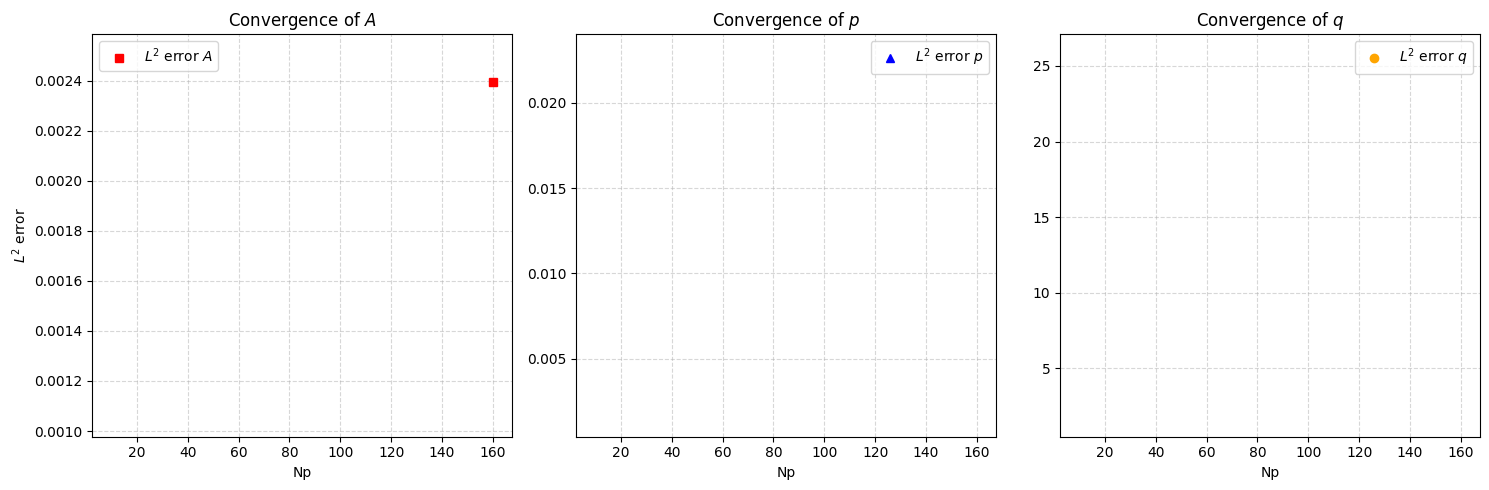

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # No sharey=True

def set_custom_ylim(ax, data, padding_ratio=0.1):
    """Set y-limits with padding based on data range."""
    y_min, y_max = np.min(data), np.max(data)
    padding = (y_max - y_min) * padding_ratio
    ax.set_ylim(y_min - padding, y_max + padding)

# Q plot
axes[2].plot(Np_list, L2_errors_q, 'o', label=r'$L^2$ error $q$', color="orange")
axes[2].set_title("Convergence of $q$")
axes[2].set_xlabel('Np')
axes[0].set_ylabel(r'$L^2$ error')
set_custom_ylim(axes[0], L2_errors_q)
axes[2].grid(True, which='both', ls='--', alpha=0.5)
axes[2].legend()

# A plot
axes[0].plot(Np_list, L2_errors_A, 's', label=r'$L^2$ error $A$', color="red")
axes[0].set_title("Convergence of $A$")
axes[0].set_xlabel('Np')
set_custom_ylim(axes[1], L2_errors_A)
axes[0].grid(True, which='both', ls='--', alpha=0.5)
axes[0].legend()

# P plot
axes[1].plot(Np_list, L2_errors_p, '^', label=r'$L^2$ error $p$', color="blue")
axes[1].set_title("Convergence of $p$")
axes[1].set_xlabel('Np')
set_custom_ylim(axes[2], L2_errors_p)
axes[1].grid(True, which='both', ls='--', alpha=0.5)
axes[1].legend()

plt.tight_layout()
plt.show()

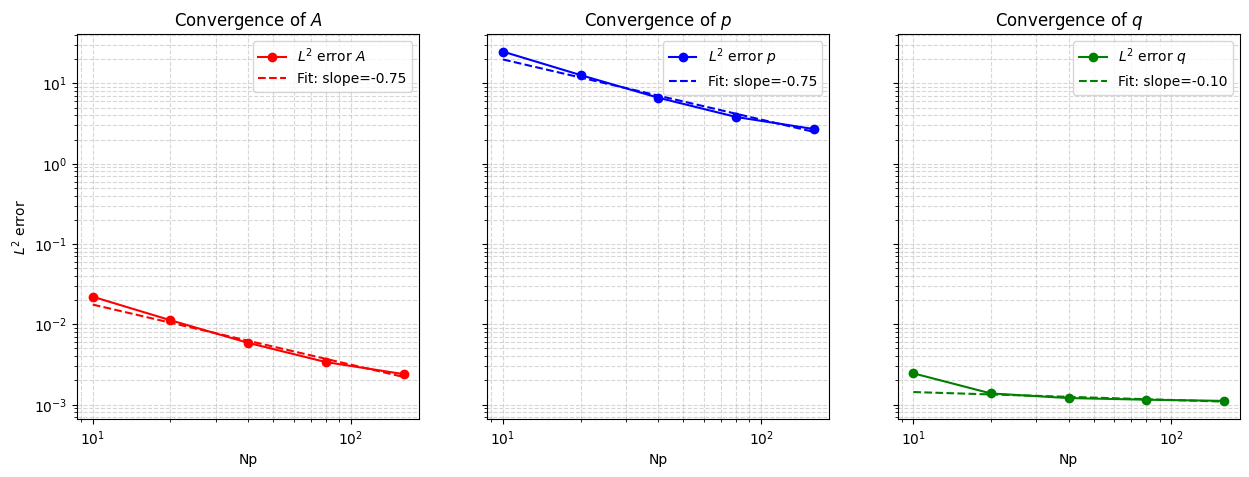

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Q plot
axes[2].loglog(Np_list, L2_errors_q, 'o-', label=r'$L^2$ error $q$', color="green")
axes[2].loglog(Np_list, fit_line_q, '--', label=f'Fit: slope={slope_q:.2f}', color="green")
axes[2].set_title("Convergence of $q$")
axes[2].set_xlabel('Np')
axes[0].set_ylabel(r'$L^2$ error')
axes[2].grid(True, which='both', ls='--', alpha=0.5)
axes[2].legend()

# A plot
axes[0].loglog(Np_list, L2_errors_A, 'o-', label=r'$L^2$ error $A$', color="red")
axes[0].loglog(Np_list, fit_line_A, '--', label=f'Fit: slope={slope_A:.2f}', color="red")
axes[0].set_title("Convergence of $A$")
axes[0].set_xlabel('Np')
axes[0].grid(True, which='both', ls='--', alpha=0.5)
axes[0].legend()

# P plot
axes[1].loglog(Np_list, L2_errors_p, 'o-', label=r'$L^2$ error $p$', color="blue")
axes[1].loglog(Np_list, fit_line_p, '--', label=f'Fit: slope={slope_p:.2f}', color="blue")
axes[1].set_title("Convergence of $p$")
axes[1].set_xlabel('Np')
axes[1].grid(True, which='both', ls='--', alpha=0.5)
axes[1].legend()

plt.show()